# Gaussianization Flows

In [1]:
from typing import Tuple, List, Callable

import numpy as np
import jax
from jax import lax
import jax.numpy as jnp
from jax.nn import log_sigmoid, logsumexp, log_softmax
from jax.nn.initializers import orthogonal

import treex

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.distributions.normal import Normal

from sklearn.datasets import make_moons

import corner
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.mixture import GaussianMixture

from tqdm.notebook import trange, tqdm

## Data

In [2]:
ntrain = 10_000
ntest = 10_000
noise = 0.1
random_state = 123
train_data = make_moons(n_samples=ntrain, noise=noise, random_state=random_state)[0]
test_data = make_moons(n_samples=ntest, noise=noise, random_state=random_state*10)[0]

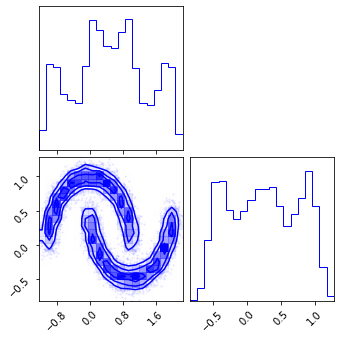

In [3]:
fig = corner.corner(train_data, color="blue")

## Gaussianization Flows

### Marginal Gaussianization

#### Initialization

In [4]:


def init_marginal_mixture_weights(
    X: np.ndarray, n_components: int, covariance_type: str = "diag", **kwargs
):
    """Initialize means with K-Means

    Parameters
    ----------
    X : np.ndarray
        (n_samples, n_features)
    n_components : int
        the number of clusters for the K-Means

    Returns
    -------
    clusters : np.ndarray
        (n_features, n_components)"""

    weights, means, covariances = [], [], []

    for iX in X.T:
        clf = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            **kwargs,
        ).fit(iX[:, None])
        weights.append(clf.weights_)
        means.append(clf.means_.T)
        covariances.append(clf.covariances_.T)

    weights = np.vstack(weights)
    means = np.vstack(means)
    covariances = np.vstack(covariances)

    # do inverse param transformations
    log_scales = tfp.math.softplus_inverse(jnp.sqrt(covariances))
    prior_logits = jnp.log(weights)

    return prior_logits, means, log_scales

### PDF

We are going to use the same function as before. The only difference is the we will use the PDF instead of the CDF of a Gaussian.

$$
\log \nabla U(x) = \sum_k^K \log \pi_k + \log \sum_k^K \mathcal{N}_{PDF}(x|\mu_k, \sigma_k)
$$

In [5]:
# num_mixtures = 4

# X = jnp.asarray(train_data)

# logit_weights, means, scales = init_marginal_mixture_weights(train_data, num_mixtures)

# logit_weights = jnp.log(weights)
# means = jnp.asarray(means)
# log_scales = jnp.log(scales)

In [6]:

# from 
# from distrax._src.utils import 

In [7]:




def sum_except_batch(x, num_dims=1):
    '''
    Sums all dimensions except the first.
    Args:
        x: Tensor, shape (batch_size, ...)
        num_dims: int, number of batch dims (default=1)
    Returns:
        x_sum: Tensor, shape (batch_size,)
    '''
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)

class GaussianMixtureCDF(tx.Module):
    logit_weights: jnp.ndarray = tx.Parameter.node()
    means: jnp.ndarray = tx.Parameter.node()
    log_scales: jnp.ndarray = tx.Parameter.node()
    num_mixtures: int
    eps: float
    max_iters: int

    def __init__(self, num_mixtures: int = 5, eps: float = 1e-5, max_iters: int = 100):

        self.num_mixtures = num_mixtures
        self.eps = eps
        self.max_iters = max_iters

    def __call__(self, x):
        if self.initializing():
            # self.logit_weights = jnp.log(jnp.ones(x.shape[0], self.num_mixtures) / self.num_mixtures)
            # self.means = jnp.ones(self.num_features, self.num_mixtures)
            # self.log_scales = jnp.log(0.1 * jnp.ones((self.num_features, self.num_mixtures)))
            # data-dependent initialization
            logit_weights, means, log_scales = init_marginal_mixture_weights(
                np.asarray(x),
                n_components=self.num_mixtures,
            )
            self.logit_weights = jnp.array(logit_weights)
            self.means = jnp.array(means)
            self.log_scales = jnp.array(log_scales)
            
        z = self.transform(x)
        
        ldj = self.forward_log_det_jacobian(x)
        
        return z, ldj

    
    def transform(self, x: jnp.ndarray) -> np.ndarray:
        return mixture_gaussian_cdf(x, self.logit_weights, self.means, self.log_scales)
    
    def inverse_transform(self, z: jnp.ndarray) -> np.ndarray:
        
        max_scales = jnp.sum(jnp.exp(self.log_scales), axis=-1, keepdims=True)
        init_lower, _ = jnp.min(self.means - 20 * max_scales, axis=-1)
        init_upper, _ = jnp.min(self.means + 20 * max_scales, axis=-1)
        
        fn = lambda x: mixture_gaussian_cdf(x, self.logit_weights, self.means, self.log_scales)
        
        x = bisection_inverse(
            fn=fn, z=z, init_x=jnp.zeros_like(z), 
            init_lower=init_lower, init_upper=init_upper,
            eps=self.eps, max_iters=self.max_iters
        )
        
        return x
    
    def forward_log_det_jacobian(self, x):
        ldj = mixture_gaussian_pdf(x, self.logit_weights, self.means, self.log_scales)
        
        ldj = sum_except_batch(ldj)
        return ldj
    
                                      
                                      
        
def mixture_gaussian_cdf(x, logit_weights, means, log_scales):
    
    x = jnp.expand_dims(x, axis=-1)
    
    log_weights = log_softmax(logit_weights, axis=-1)

    dist = tfd.Normal(loc=means, scale=jnp.exp(log_scales))

    
    z = jnp.sum(jnp.exp(log_weights) * dist.cdf(x), axis=-1)
    
    return z

def mixture_gaussian_pdf(x, logit_weights, means, log_scales):
    
    x = jnp.expand_dims(x, axis=-1)
    
    log_weights = log_softmax(logit_weights, axis=-1)
    
    dist = tfd.Normal(means, jnp.exp(log_scales))
    
    z_pdf = logsumexp(log_weights + dist.log_prob(x), axis=-1)
    
    return z_pdf

def bisection_inverse(fn, z, init_x, init_lower, init_upper, eps=1e-10, max_iters=100):
    '''Bisection method to find the inverse of `fn`. Computed by finding the root of `z-fn(x)=0`.'''

    def body(x_, lb_, ub_, cur_z_):
        gt = (cur_z_ > z).astype(z.dtype)
        lt = 1 - gt
        new_x_ = gt * (x_ + lb_) / 2. + lt * (x_ + ub_) / 2.
        new_lb = gt * lb_ + lt * x_
        new_ub = gt * x_ + lt * ub_
        return new_x_, new_lb, new_ub

    x, lb, ub = init_x, init_lower, init_upper
    cur_z = fn(x)
    diff = float('inf')
    i = 0
    while diff > eps and i < max_iters:
        x, lb, ub = body(x, lb, ub, cur_z)
        cur_z = fn(x)
        diff = jnp.max(jnp.abs((z - cur_z)))
        i += 1

    return x

In [8]:
num_mixtures = 4

# init bijector
mu_bijector = GaussianMixtureCDF(num_mixtures=num_mixtures)

# init data
x_init = jnp.array(train_data)

mu_bijector = mu_bijector.init(key=123, inputs=x_init)

# forward pass
z_mu, ldj = mu_bijector(x_init)
z_mu = mu_bijector.transform(x_init)
x_approx = mu_bijector.inverse_transform(z_mu)


params = mu_bijector.parameters()
params

GaussianMixtureCDF {
    eps: 1e-05,
    log_scales: jaxlib.DeviceArray((2, 4), float32),       Parameter
    logit_weights: jaxlib.DeviceArray((2, 4), float32),    Parameter
    max_iters: 100,
    means: jaxlib.DeviceArray((2, 4), float32),            Parameter
    name: "gaussian_mixture_cdf",                          str
    num_mixtures: 4,
}

In [9]:
# model
np.testing.assert_array_almost_equal(x_approx, x_init, decimal=5)

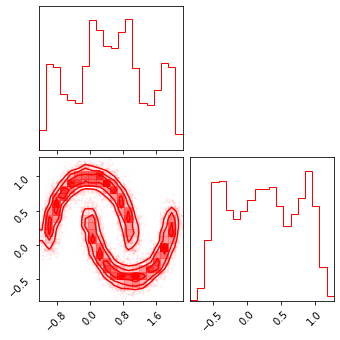

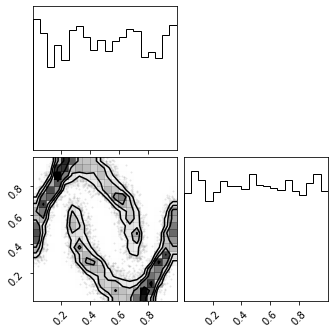

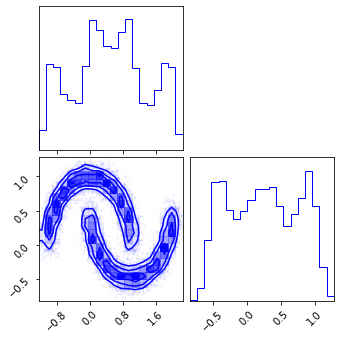

In [10]:
fig = corner.corner(np.array(x_init), color="red")
fig = corner.corner(np.array(z_mu), color="black")
fig = corner.corner(np.array(x_approx), color="blue")

## Inverse CDF

In [11]:


def _clamp_preserve_gradients(x, min, max):
    return x + lax.stop_gradient(jnp.clip(x, a_min=min, a_max=max) - x)


class InverseGaussCDF(tx.Module):
    eps: float

    
    def __init__(self, eps: float=1e-7):
        
        self.eps = eps
        # self.base_dist = tfd.Normal(loc=0, scale=1)
                                      
    def __call__(self, x: jnp.ndarray) -> np.ndarray:
                
        z = self.transform(x)
        
        # ldj
        ldj = - self.dist.log_prob(z)
        ldj = sum_except_batch(ldj)
        
        return z, ldj
    
    def transform(self, x: jnp.ndarray) -> np.ndarray:
        x = jnp.clip(x, self.eps, 1-self.eps)
        # x = _clamp_preserve_gradients(x, self.eps, 1 - self.eps)
        
        return self.dist.quantile(x)
    
    def inverse_transform(self, z: jnp.ndarray) -> np.ndarray:
        return self.dist.cdf(z)
    
    def forward_log_det_jacobian(self, x):
                
        # forward transform
        z = self.transform(x)
        
        # ldj
        ldj = - self.dist.log_prob(z)
        
        return sum_except_batch(ldj)
    
    @property
    def dist(self):
        return tfd.Normal(loc=0, scale=1)

In [12]:
eps = 1e-5

# init bijector
icdf_bijector = InverseGaussCDF(eps=eps)


icdf_bijector = icdf_bijector.init(key=123, inputs=z_mu)

# forward pass
z_mg, ldj = icdf_bijector(z_mu)
z_mg = icdf_bijector.transform(z_mu)
x_approx = icdf_bijector.inverse_transform(z_mg)

np.testing.assert_array_almost_equal(x_approx, z_mu, decimal=5)

params = icdf_bijector.parameters()
params



InverseGaussCDF {
    eps: 1e-05,
    name: "inverse_gauss_cdf",    str
}

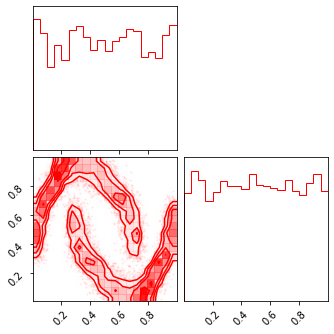

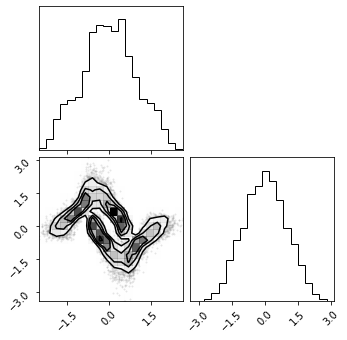

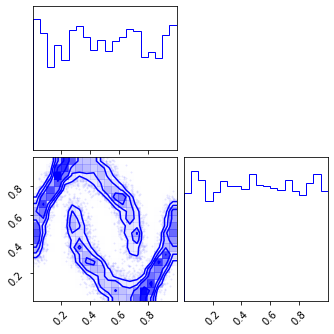

In [13]:
fig = corner.corner(np.array(z_mu), color="red")
fig = corner.corner(np.array(z_mg), color="black")
fig = corner.corner(np.array(x_approx), color="blue")

## Random Rotations

In [14]:


class RandomRotation(tx.Module):
    V: jnp.ndarray

    def __call__(self, x):

        if self.initializing():

            # random initialization
            key = tx.next_key()
            self.V = orthogonal()(key=key, shape=[x.shape[1], x.shape[1]])
            
        z = self.transform(x)
        ldj = self.forward_log_det_jacobian(x)

        return z, ldj

    def transform(self, x):
        return jnp.dot(x, self.V)

    def inverse_transform(self, x):
        return jnp.dot(x, self.V.T)

    def forward_log_det_jacobian(self, x):
        return jnp.zeros_like(x[:,0])

In [15]:

# init bijector
rot_bijector = RandomRotation()


rot_bijector = rot_bijector.init(key=123, inputs=z_mg)

# forward pass
z_rot, ldj = rot_bijector(z_mg)
z_rot = rot_bijector.transform(z_mg)
z_mg_approx = rot_bijector.inverse_transform(z_rot)

np.testing.assert_array_almost_equal(z_mg_approx, z_mg, decimal=5)


params = rot_bijector.parameters()
params

RandomRotation {
    V: jaxlib.DeviceArray((2, 2), float32),
    name: "random_rotation",                   str
}

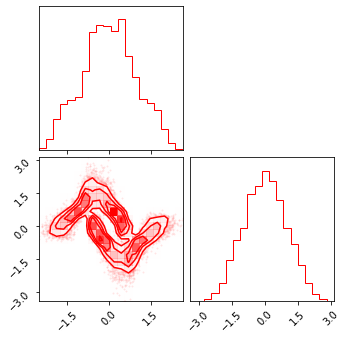

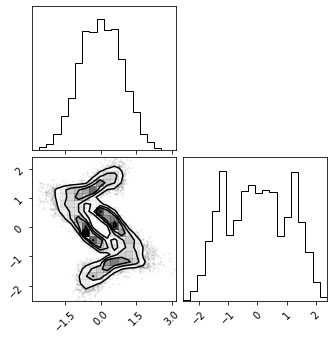

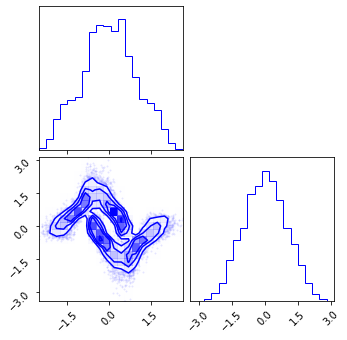

In [16]:
fig = corner.corner(np.array(z_mg), color="red")
fig = corner.corner(np.array(z_rot), color="black")
fig = corner.corner(np.array(z_mg_approx), color="blue")

### Composite Transformation

So to have a flow model, we need two components:


---
**Base Distribution**: $p_Z = \mathbb{P}_Z$

This will describe the distribution we want in the transform domain. In this case, we will choose the uniform distribution because we are trying to uniformize our data.

---
**Bijections**: $f = f_L \circ f_{L-1} \circ \ldots \circ f_1$

The list of bijections. These are our functions which we would like to compose together to get our dataset.


In [17]:
class Composite(tx.Sequential):
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:

        return self.forward(x)

    def forward(self, x):
        # transform first layer
        x, ldj = self.layers[0](x)

        # loop through remaining layers
        for ibijector in self.layers[1:]:
            x, ildj = ibijector(x)
            ldj += ildj

        return x, ldj
    
    def transform(self, x):
        # loop through layers
        for layer in self.layers:
            x = layer.transform(x)
        return x


    def inverse_transform(self, x):
        # loop through layers
        for layer in reversed(self.layers):
            x = layer.inverse_transform(x)
        return x

In [18]:
# layer params
num_mixtures = 6

# create layers
bijector_block = [
    # marginal uniformization
    GaussianMixtureCDF(num_mixtures=num_mixtures), 
    # LogisticMixtureCDF(num_mixtures=num_mixtures), 
    # marginal gaussianization
    InverseGaussCDF(),
    # Logit(),
    # orthogonal transform
    RandomRotation(),
]

# multiply blocks
n_layers = 6
bijectors = bijector_block * n_layers

In [19]:
# create composite
model = Composite(*bijectors)

# init keys and data
x_init = jnp.array(train_data)
key_init = jax.random.PRNGKey(123)

# init layer params (data-dependent)
model = model.init(key=123, inputs=x_init)

params = model.parameters()
print(params)

Composite {
    layers: list [
        GaussianMixtureCDF {
            eps: 1e-05,
            log_scales: jaxlib.DeviceArray((2, 6), float32),       Parameter
            logit_weights: jaxlib.DeviceArray((2, 6), float32),    Parameter
            max_iters: 100,
            means: jaxlib.DeviceArray((2, 6), float32),            Parameter
            name: "gaussian_mixture_cdf",                          str
            num_mixtures: 6,
        },
        InverseGaussCDF {
            eps: 1e-07,
            name: "inverse_gauss_cdf",                             str
        },
        RandomRotation {
            V: jaxlib.DeviceArray((2, 2), float32),
            name: "random_rotation",                               str
        },
        GaussianMixtureCDF {
            eps: 1e-05,
            log_scales: jaxlib.DeviceArray((2, 6), float32),       Parameter
            logit_weights: jaxlib.DeviceArray((2, 6), float32),    Parameter
            max_iters: 100,
            means: j

In [22]:
z = model(x_init)
z, ldj = model(x_init)
x_approx = model.inverse_transform(z)


np.testing.assert_array_almost_equal(x_approx, x_init, decimal=0)

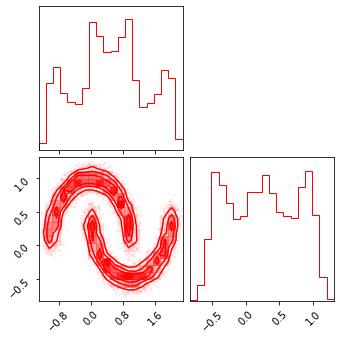

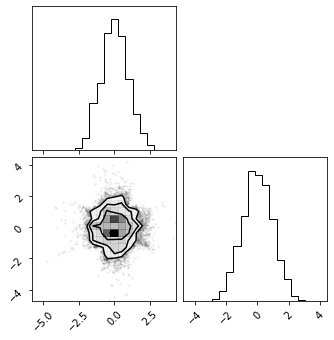

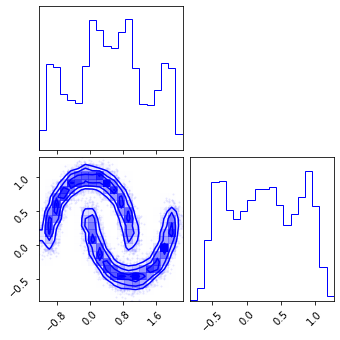

In [23]:
fig = corner.corner(np.array(test_data), color="red")
fig = corner.corner(np.array(z), color="black")
fig = corner.corner(np.array(x_approx), color="blue")

In [24]:



    
# class FlowModel(tx.Module):
#     layers: tx.Sequential = tx.State.node()
    
    
#     def __init__(self, layers, base_dist):
#         self.layers = layers
#         self.base_dist
    
#     def __call__(self, x):
#         return self.layers(x)
    
#     def log_prob(self, x: jnp.ndarray):
#         # forward propagation
#         z, ldj = self.layers(x)
        
#         # latent log prob
#         return None
    
#     def sample(self, shape):
#         raise NotImplementedError()
    

## Training

### Loss

In [25]:

# base_dist = tfd.Normal(jnp.zeros(2), jnp.ones(2))
base_dist = tfd.MultivariateNormalDiag(jnp.zeros(2), jnp.ones(2))
# base_dist = tfd.Uniform()

# differentiate only w.r.t. parameters
def loss_fn(params, model, x):
    # merge params into model
    model = model.merge(params)

    # forward transformation
    z, ldj = model(x)
    
    # latent prob
    latent_prob = base_dist.log_prob(z)

    # calculate log prob
    log_prob = sum_except_batch(latent_prob) + sum_except_batch(ldj)
    
    # calculate nll
    loss = - jnp.mean(log_prob)

    # the model may contain state updates
    # so it should be returned
    return loss, model


In [26]:
params = model.parameters()
loss, model_ = loss_fn(params, model, x_init)

loss

DeviceArray(1.1661366, dtype=float32)

### Gradients

In [27]:
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

(loss_, m_), grads_ = grad_fn(params, model, x_init)

loss_

DeviceArray(1.1661366, dtype=float32)

### Train Step

In [28]:
# both model and optimizer are jit-able
@jax.jit
def train_step(model, x, optimizer):
    # select only the parameters
    params = model.parameters()

    (loss, model), grads = grad_fn(params, model, x)

    # update params and model
    params = optimizer.update(grads, params)
    model = model.merge(params)

    # return new model and optimizer
    return loss, model, optimizer

### Optimizers

In [29]:
import optax

# learning rate
lr = 0.001

# scheduler (TODO)
optimizer = tx.Optimizer(optax.adam(lr)).init(model)

### Training

In [30]:


n_iterations = 20_000
losses = []
batch_size = 64

with trange(n_iterations) as pbar:
    for i in pbar:
        # train_data = get_toy_data(n_samples=batch_size, seed=i)
        train_data = make_moons(n_samples=batch_size, noise=noise, random_state=i)[0]
        
        ibatch = jnp.array(train_data)
        loss, model, optimizer = train_step(model, ibatch, optimizer)
        
        pbar.set_description(f"Loss: {loss:.4f}")
        losses.append(loss)

  0%|          | 0/20000 [00:00<?, ?it/s]

2022-01-13 14:58:39.950953: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Slow compile?  XLA was built without compiler optimizations, which can be slow.  Try rebuilding with -c opt.
Compiling module jit_train_step.11307
********************************


## Results

In [31]:
model = model.eval()

### Losses

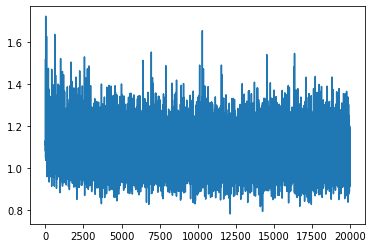

In [32]:
fig, ax = plt.subplots()

ax.plot(losses)

plt.show()

### Latent Space

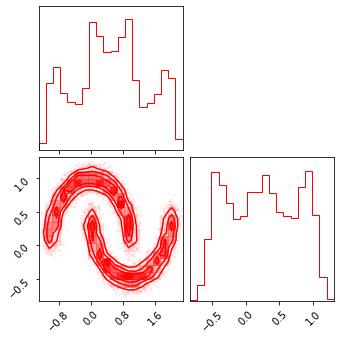

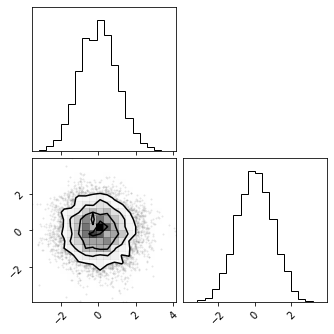

In [33]:
z = model.transform(test_data)

fig = corner.corner(np.array(test_data), color="red")
fig = corner.corner(np.array(z), color="black")

### Inverse Transform

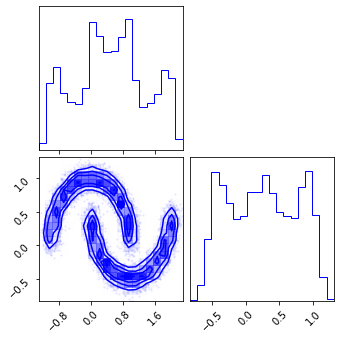

In [34]:
x_approx = model.inverse_transform(z)

fig = corner.corner(np.array(x_approx), color="blue")

### Generated Samples

In [35]:
z_samples = base_dist.sample(sample_shape=(100_000), seed=key_init)

In [36]:
x_samples = model.inverse_transform(z_samples)

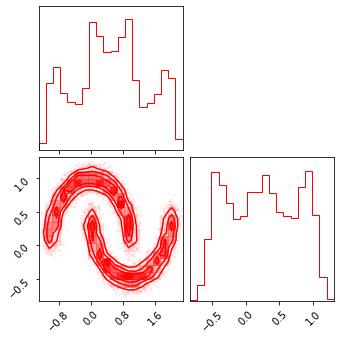

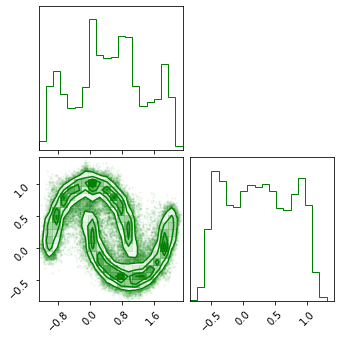

In [37]:
fig = corner.corner(np.array(test_data), color="red")
fig = corner.corner(np.array(x_samples), color="green")

## Density Estimation

In [38]:
def generate_2d_grid(data: np.ndarray, n_grid: int = 1_000, buffer: float = 0.01) -> np.ndarray:

    xline = np.linspace(data[:, 0].min() - buffer, data[:, 0].max() + buffer, n_grid)
    yline = np.linspace(data[:, 1].min() - buffer, data[:, 1].max() + buffer, n_grid)
    xgrid, ygrid = np.meshgrid(xline, yline)
    xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)
    return xyinput

In [39]:
xyinput = generate_2d_grid(test_data, 500, buffer=0.1)

In [40]:
# forward transformation
z, ldj = model(xyinput)

# latent prob
latent_prob = base_dist.log_prob(z)

# calculate log prob
x_log_prob = sum_except_batch(latent_prob) + sum_except_batch(ldj)

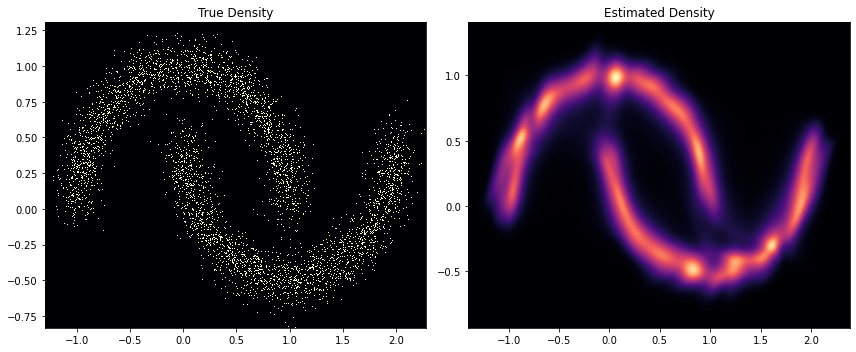

In [41]:



# # Original Density
# n_samples = 1_000_000
# n_features = 2
# X_plot = load_data(n_samples, 42)
# X_plot = StandardScaler().fit_transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = np.exp(x_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"
# cmap = "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    test_data[:, 0], test_data[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[test_data[:, 0].min(), test_data[:, 0].max()],
    ylim=[test_data[:, 1].min(), test_data[:, 1].max()],
)


h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, #vmin=0.0, vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()